In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from nnfs.datasets import spiral_data
import torch; import torch.nn as nn; import torch.functional as F; import torch.distributions as dist
from collections import OrderedDict

Error function for Gaussian Mixed Density Network for regression, from Bishop:
$$E(\mathbf{w}) = - \sum_{n=1}^N\ln \bigg\{\sum_{k=1}^K \pi_k(\mathbf{x}_n, \mathbf{w})\mathcal{N}\big(\mathbf{t}_n|\mathbf{\mu}_k(\mathbf{x}_n, \mathbf{w}), \ \sigma_k^2(\mathbf{x}_n, \mathbf{w})\big)\bigg\}$$

In [29]:
# gmm loss function for regression
def gmm_loss(t, pi, mu, sigma, eps=1e-8):
    gaussian = dist.Normal(mu, sigma)          # normal dist
    log_pi = torch.log(pi + eps)               # Avoid log(0) disaster
    log_probs = gaussian.log_prob(t) + log_pi  # equiv ln(pi * p(t))

    # sum over channels & observations (dim=0) and (dim=1)
    loss = -torch.logsumexp(log_probs, dim=1)  # log of summed probs over K; [N]
    return loss.mean()  # return average over N observations

In [44]:
# MDN for regression
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians, n_layers: int = 2, activation: str = 'relu'):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.losses = []

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError('Invalid activation function')
        
        # initialize layers
        hidden_layers_list = OrderedDict([
            ('l1', nn.Linear(1, n_hidden)),
            ('act1', nn.ReLU()),
        ])
        for i in range(2, n_layers):
            hidden_layers_list.update([
                (f'l{i}', nn.Linear(n_hidden, n_hidden)), 
                (f'act{i}', nn.ReLU())
            ])
            
        # wrap layers with a Sequential container
        self.hidden = nn.Sequential(hidden_layers_list)

        # output layers
        self.pi = nn.Linear(n_hidden, n_gaussians)
        self.mu = nn.Linear(n_hidden, n_gaussians)
        self.sigma = nn.Linear(n_hidden, n_gaussians)
    

    def forward(self, x):
        # forward through the network
        x = self.hidden(x)             # [N, n_hidden]
        pi = self.pi(x)                # [N, n_gaussians]
        mu = self.mu(x)                # [N, n_gaussians]
        sigma = self.sigma(x)          # [N, n_gaussians]

        # apply output layer activations
        pi = torch.softmax(pi, dim=1)  # ensure pi sums to 1
        mu = mu                        # identity activation
        sigma = torch.exp(sigma)       # ensure sigma is positive

        return pi, mu, sigma
    
    def train(self, x, t, lr: float = 0.001, epochs: int = 1000, batch_size: int = 10):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for batch in range(len(x) // batch_size):
                batch_indices = torch.randint(low=0, high=len(x), size=(batch_size,))
                pi, mu, sigma = self.forward(x=x[batch_indices])
                loss = gmm_loss(t[batch_indices], pi, mu, sigma)

                optimizer.zero_grad()  # clear gradients
                loss.backward()        # update gradients
                optimizer.step()       # update weights

            self.losses.append(loss.item())

In [80]:
def sample_preds(pi, mu, sigma, max_prob: bool = True):
    N, K = mu.shape
    if max_prob:
        k = torch.argmax(pi, dim=1)
    else:
        k = torch.multinomial(pi, num_samples=1)
    preds = torch.zeros(N)
    means = torch.zeros(N)
    for i in range(k.shape[0]):
        preds[i] = torch.normal(mu[i, k[i]], sigma[i, k[i]])
        means[i] = mu[i, k[i]]
    return preds, means

First test case for regression: spiral

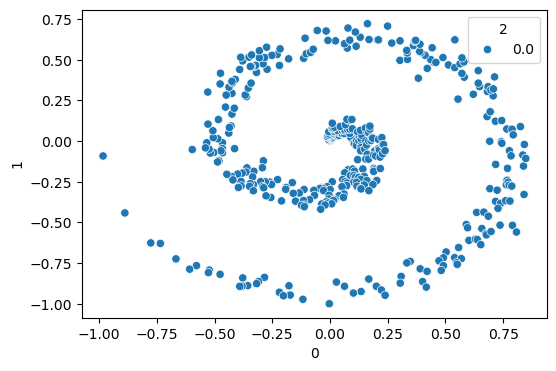

In [45]:
n_classes = 1
X, y = spiral_data(samples=400, classes=n_classes)  # y is the class assignments
df = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1))
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df.iloc[:, 2])

plt.show();

In [46]:
x, y = df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy()
x, y = torch.from_numpy(x).float().view(-1, 1), torch.from_numpy(y).float().view(-1, 1)

In [87]:
def plot_preds(model, x, y, max_prob: bool = True):  
    sx = x.sort(dim=0).values
    pi, mu, sigma = model.forward(sx)
    preds, means = sample_preds(pi, mu, sigma, max_prob)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    ax1.scatter(x, y, label='True')
    ax1.scatter(sx, preds.detach(), alpha=0.75, label='Predicted')
    ax1.legend()
    ax2.scatter(x, y, label='True')
    ax2.scatter(sx, means.detach(), alpha=0.75, label='Gaussian Means')
    ax2.legend()
    ax3.plot(model.losses)
    plt.show();

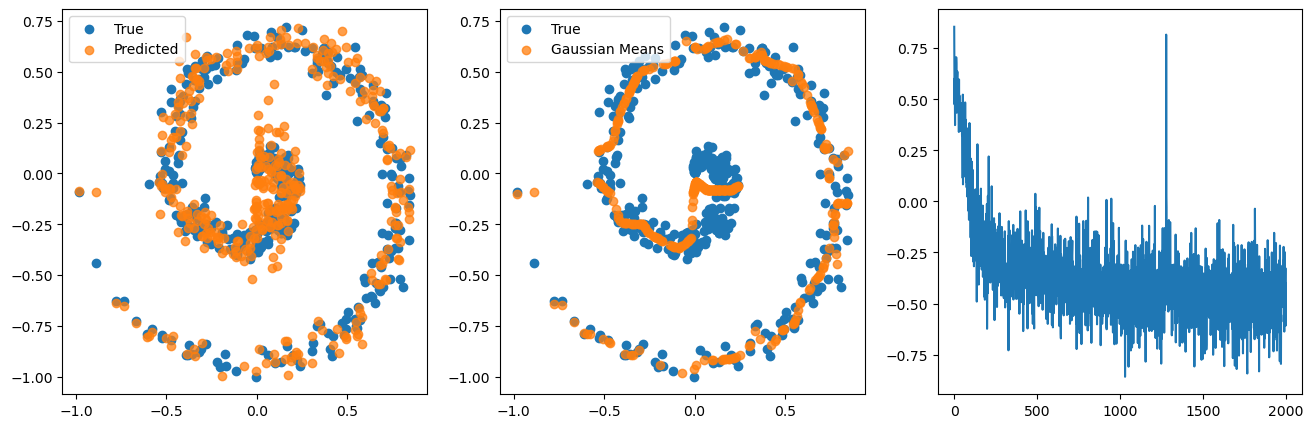

In [89]:
model = MDN(n_hidden=64, n_gaussians=4, n_layers=4, activation='relu')
model.train(x, y, lr=0.001, epochs=2000, batch_size = x.shape[0] // 10)
plot_preds(model, x, y, max_prob=False)

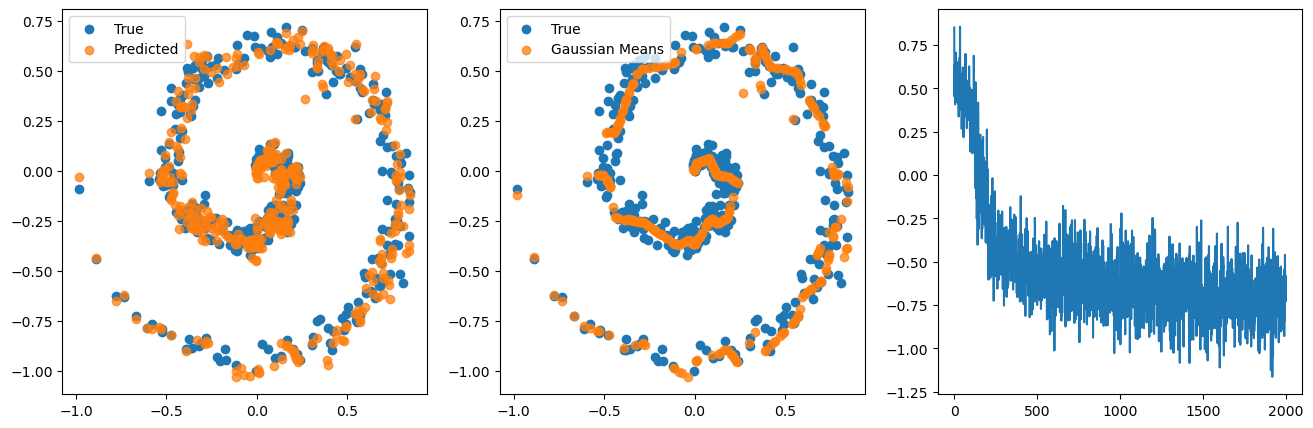

In [90]:
model2 = MDN(n_hidden=64, n_gaussians=4, n_layers=4, activation='tanh')
model2.train(x, y, lr=0.001, epochs=2000, batch_size = x.shape[0] // 10)
plot_preds(model2, x, y, max_prob=False)

Let's try fitting multiple spirals:

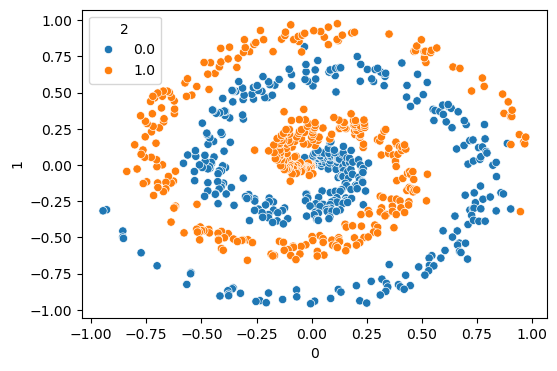

In [91]:
n_classes = 2
X, y = spiral_data(samples=400, classes=n_classes)  # y is the class assignments
df = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1))
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df.iloc[:, 2])

plt.show();

In [92]:
x, y = df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy()
x, y = torch.from_numpy(x).float().view(-1, 1), torch.from_numpy(y).float().view(-1, 1)

So, my thinking is that we need at least as many Gaussians as possible mappings from `x` to `y`. With two spirals, it looks like the maximum number of disparate mappings is 8, occuring roughly around `x = 0.00`. Let's try that out:

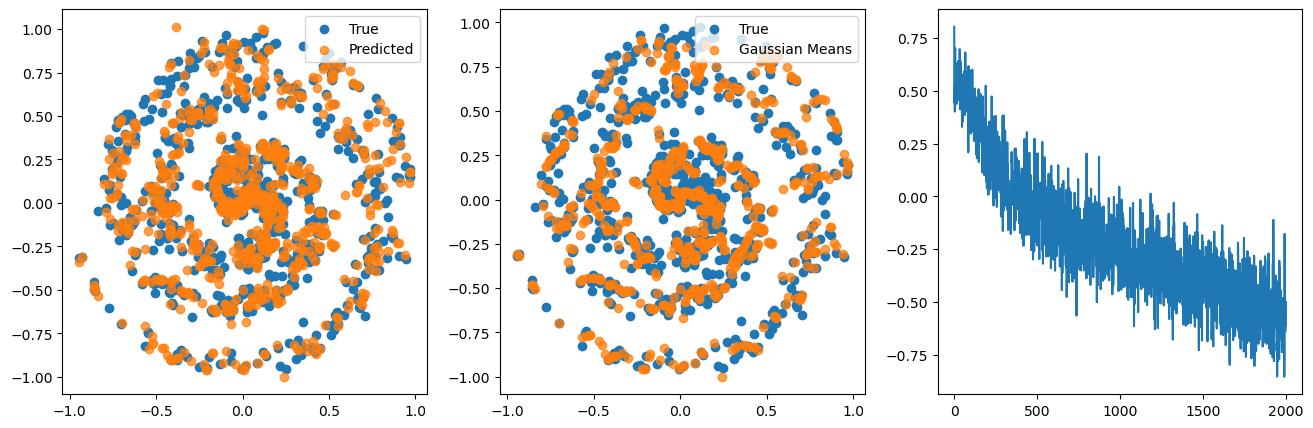

In [94]:
model3 = MDN(n_hidden=128, n_gaussians=8, n_layers=6, activation='tanh')
model3.train(x, y, lr=0.001, epochs=2000, batch_size = x.shape[0] // 10)
plot_preds(model3, x, y, max_prob=False)

Honestly, this is pretty good. Let's see how it looks if we only fit 4 Gaussians as we did for the single spiral:

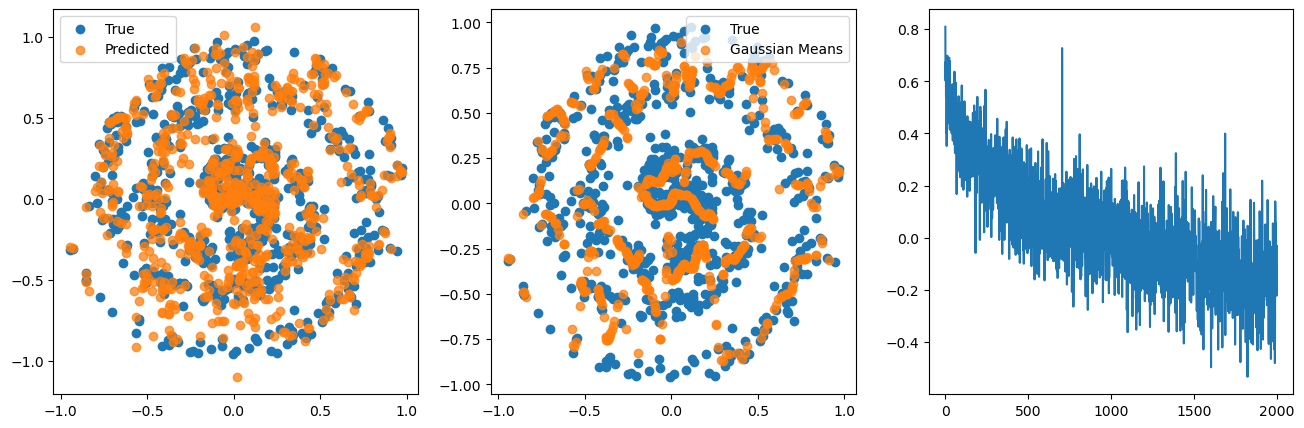

In [96]:
model4 = MDN(n_hidden=128, n_gaussians=4, n_layers=6, activation='tanh')
model4.train(x, y, lr=0.001, epochs=2000, batch_size = x.shape[0] // 10)
plot_preds(model4, x, y, max_prob=False)

This is better than I had expected. It looks like it compensates by fitting the means closer to midpoints between the two spirals. So, the randomly sampled predictions are consequentially a bit more diffuse. It seems like the optimal number of Gaussians should be eight or more because we'd like to fit a Gaussian for each potential value of `y`. However, how should we go about finding the optimal number? Will we ever be at risk of overfitting (since the predictions are inherently random)?

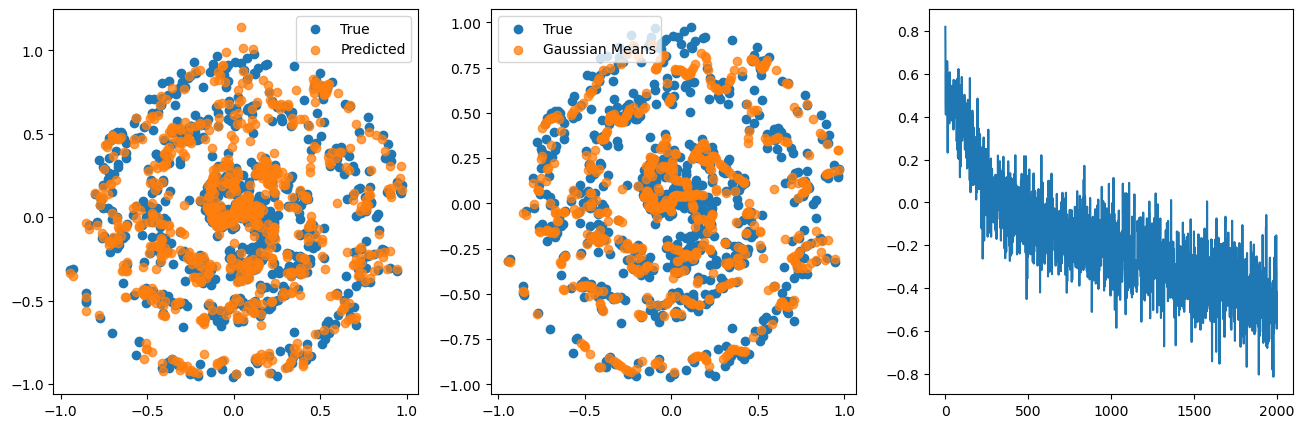

In [97]:
model5 = MDN(n_hidden=128, n_gaussians=16, n_layers=6, activation='tanh')
model5.train(x, y, lr=0.001, epochs=2000, batch_size = x.shape[0] // 10)
plot_preds(model5, x, y, max_prob=False)

This really seems no better than the model fit with 8 Gaussians...

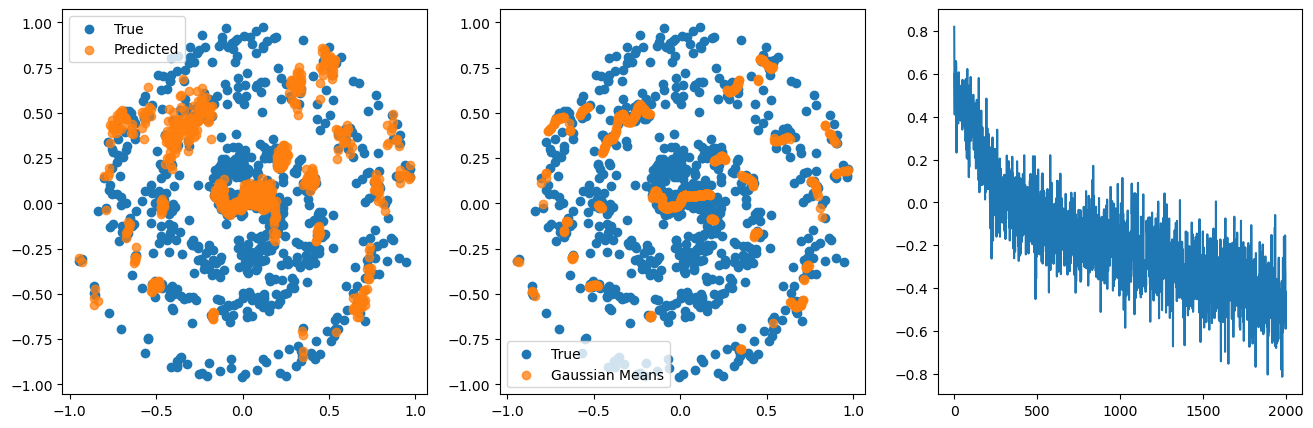

In [98]:
plot_preds(model5, x, y, max_prob=True)